<a href="https://colab.research.google.com/github/zachfreitas/ADS_505_Applied_Data_Sci_for_Business-/blob/main/Module_3/Assignment_3/Zachariah_Freitas_Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3.1
Zachariah Freitas <br>
2022-09-24

Import required packages

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
!pip install dmba

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

import matplotlib.pylab as plt

from dmba import plotDecisionTree, gainsChart, liftChart
from dmba import classificationSummary, regressionSummary
import dmba

%matplotlib inline

---
## Question 1
How can a predictive model based on these data be used by Yourcabs.com? (10
Points)


---
**Question 1 Answer:**
A predictive model, based on the data we have, can be used by Yourcabs.com to predict the probability of cancelation. We can use the probably of cancelation to only show ride requests to taxi drivers with the least probability of canceling. This way we reduce the overall cancel rate from 7.43% to something lower. We want to do this so that we don’t delay our customers or worse, leave them high and dry. We expect that decreasing cancellations will increase customer satisfaction which will lead to more revenue and increased profits.
---

---
## Question 2
How can a profiling model (identifying predictors that distinguish canceled/uncanceled trips) be used by Yourcabs.com? (10 Points)

---
**Question 2 Answer:**
We can use a profiling model to help us determine which variables are important for predicting canceled and non-canceled rides. We do this by using a model that has regularization built into it. Regularization will allow us to see what variables that model determines is important for predicting our outcome, in this instance ride cancellation. It will also show us which variables are not informative to the model. With this additional information, we may want to reevaluate the noninformative variables to see if they would benefit from any additional transformation before we totally rule them out.
---

---
## Question 3
Explore, prepare, and transform the data to facilitate predictive modeling. Here are some
hints: (15 Points)

## Data ETL and EDA

In [28]:
# Load the data
taxi_df = pd.read_csv('https://raw.githubusercontent.com/zachfreitas/ADS_505_Applied_Data_Sci_for_Business-/main/Module_3/Assignment_3/Taxi-cancellation-case.csv')
taxi_df.head()

,row#,user_id,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,from_date,to_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,to_lat,to_long,Car_Cancellation
0,1,17712,12,NaN,2,1021.0,1323.0,NaN,NaN,1/1/13 22:33,NaN,0,0,1/1/13 8:01,13.028530,77.54625,12.869805,77.653211,0
1,2,17037,12,NaN,2,455.0,1330.0,NaN,NaN,1/1/13 12:43,NaN,0,0,1/1/13 9:59,12.999874,77.67812,12.953434,77.706510,0
2,3,761,12,NaN,2,814.0,393.0,NaN,NaN,1/2/13 0:28,1/3/13 0:00,1,0,1/1/13 12:14,12.908993,77.68890,13.199560,77.706880,0
3,4,868,12,NaN,2,297.0,212.0,NaN,NaN,1/1/13 13:12,NaN,0,0,1/1/13 12:42,12.997890,77.61488,12.994740,77.607970,0
4,5,21716,28,NaN,2,1237.0,330.0,NaN,NaN,1/1/13 16:33,NaN,0,0,1/1/13 15:07,12.926450,77.61206,12.858833,77.589127,0


In [29]:
# Convert from/to lat/longs to a destination distance in kilometers.
import numpy as np

def haversine_vectorize(lon1, lat1, lon2, lat2):
  
  lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

  newlon = lon2 - lon1
  newlat = lat2 - lat1

  haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2

  dist = 2 * np.arcsin(np.sqrt(haver_formula ))
  km = 6367 * dist #6367 for distance in KM for miles use 3958
  return km

taxi_df['dist(km)'] = haversine_vectorize(taxi_df['from_long'],taxi_df['from_lat'],taxi_df['to_long'],taxi_df['to_lat'])

In [30]:
# Adjust DTypes to category types
def cat_types(df, columnName):
  df[columnName] = df[columnName].astype("category")
  return columnName

# List to Apply Function to.
cat_list = ['user_id', 'vehicle_model_id', 'package_id', 'travel_type_id']

# List Comphension
[cat_types(taxi_df, i) for i in cat_list]

['user_id', 'vehicle_model_id', 'package_id', 'travel_type_id']

In [31]:
# Look at missing values and column types
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   row#                 10000 non-null  int64   
 1   user_id              10000 non-null  category
 2   vehicle_model_id     10000 non-null  category
 3   package_id           1752 non-null   category
 4   travel_type_id       10000 non-null  category
 5   from_area_id         9985 non-null   float64 
 6   to_area_id           7909 non-null   float64 
 7   from_city_id         3706 non-null   float64 
 8   to_city_id           339 non-null    float64 
 9   from_date            10000 non-null  object  
 10  to_date              5822 non-null   object  
 11  online_booking       10000 non-null  int64   
 12  mobile_site_booking  10000 non-null  int64   
 13  booking_created      10000 non-null  object  
 14  from_lat             9985 non-null   float64 
 15  from_long           

In [33]:
# Describe our data for numberic fields
taxi_df.describe().T

,count,mean,std,min,25%,50%,75%,max
row#,10000.0,5000.500000,2886.895680,1.00000,2500.750000,5000.500000,7500.250000,10000.000000
from_area_id,9985.0,709.767752,418.968918,2.00000,393.000000,590.000000,1086.000000,1401.000000
to_area_id,7909.0,665.457833,400.628562,6.00000,393.000000,516.000000,1052.000000,1403.000000
from_city_id,3706.0,14.898003,1.190770,1.00000,15.000000,15.000000,15.000000,15.000000
to_city_id,339.0,68.318584,49.886427,4.00000,32.000000,49.000000,108.000000,203.000000
online_booking,10000.0,0.353300,0.478019,0.00000,0.000000,0.000000,1.000000,1.000000
mobile_site_booking,10000.0,0.042400,0.201510,0.00000,0.000000,0.000000,0.000000,1.000000
from_lat,9985.0,12.983301,0.085659,12.77663,12.927320,12.969368,13.006450,13.366072
from_long,9985.0,77.636423,0.058667,77.38693,77.594800,77.635750,77.687790,77.786420
to_lat,7909.0,13.026217,0.113633,12.77663,12.951850,12.982750,13.199560,13.366072


In [36]:
# Convert string date columns to datetime columns.
def datetime_feature(df,columnName):
  # Get rid of infinite values
  df.replace([np.inf, -np.inf], np.nan, inplace=True)
  # Convert Object to Datetimestamp
  df[columnName] = pd.to_datetime(df[columnName], errors='coerce')
  # Fill Values
  df[columnName + '_' + 'year'] = df[columnName].dt.year.astype('Int64')
  df[columnName + '_' + 'month'] = df[columnName].dt.month.astype('Int64')
  df[columnName + '_' + 'day'] = df[columnName].dt.day.astype('Int64')
  df[columnName + '_' + 'hour'] = df[columnName].dt.hour.astype('Int64')
  df[columnName + '_' + 'minute'] = df[columnName].dt.minute.astype('Int64')
  return columnName
   

list = ['from_date',	'to_date', 'booking_created']

# List Comphension
[datetime_feature(taxi_df, i) for i in list]

['from_date', 'to_date', 'booking_created']

In [40]:
# How far ahead are trips planned?
timedelta = taxi_df['from_date']-taxi_df['booking_created']
taxi_df['time_delta(secs)'] = timedelta.astype('timedelta64[s]').astype(np.int32) # Minutes: 'timedelta64[m]' or / 60.0  Hours: 'timedelta64[h]' or / 3600.0
taxi_df['time_delta(secs)'] 

0        52320
1         9840
2        44040
3         1800
4         5160
         ...  
9995     47040
9996    188340
9997    114180
9998    445440
9999      3540
Name: time_delta(secs), Length: 10000, dtype: int32

Categorical EDA

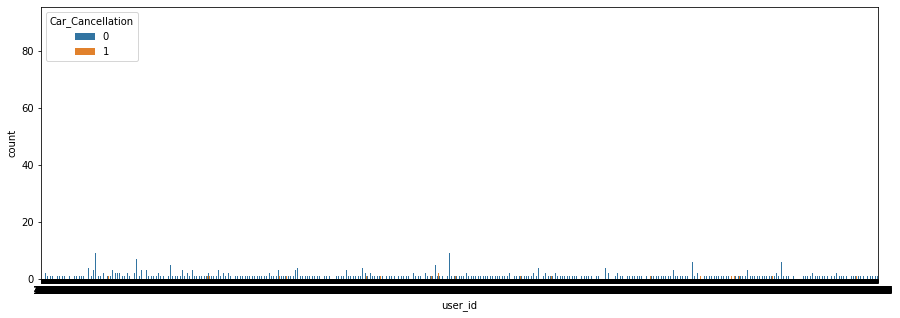

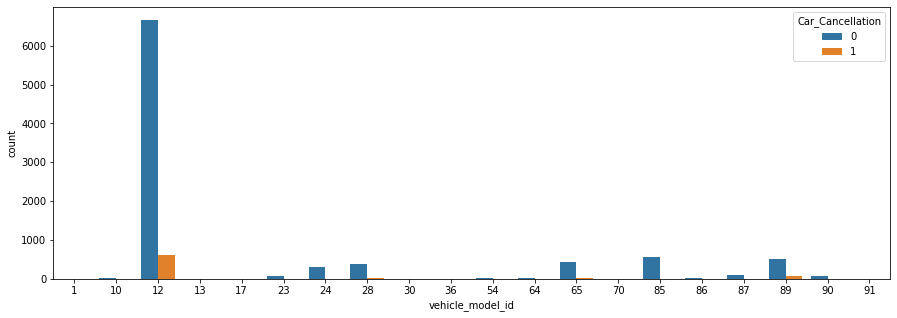

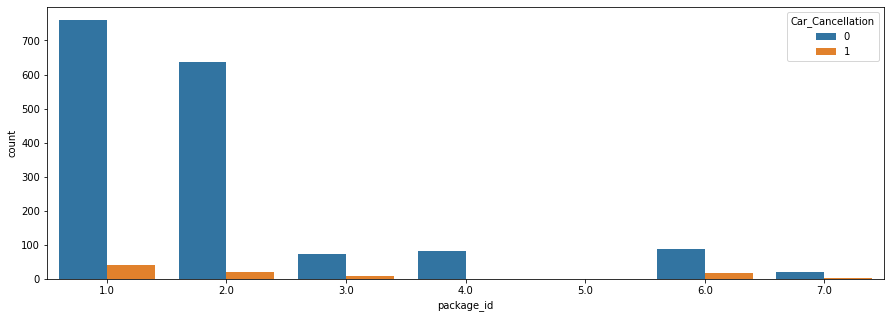

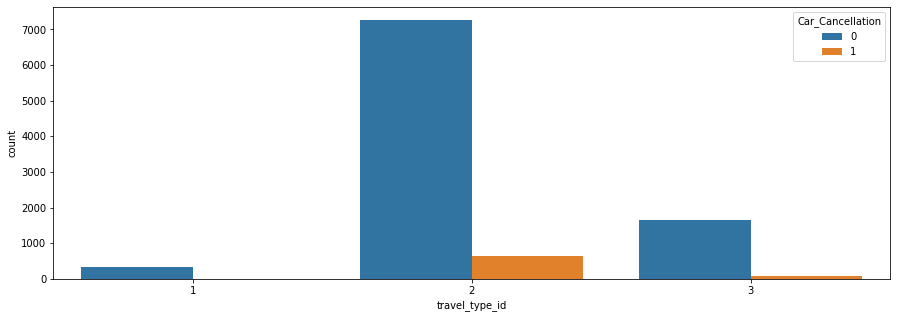

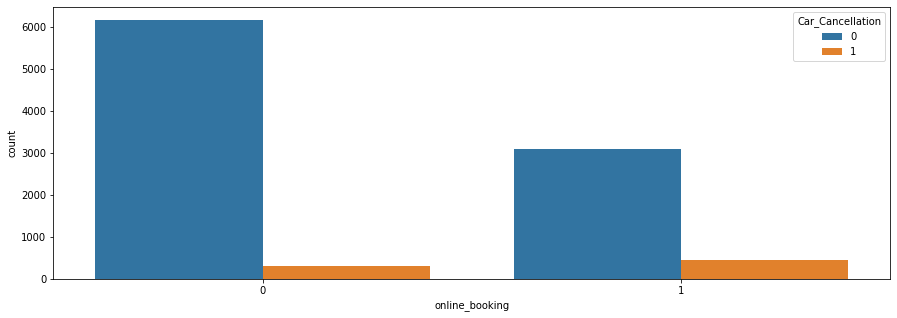

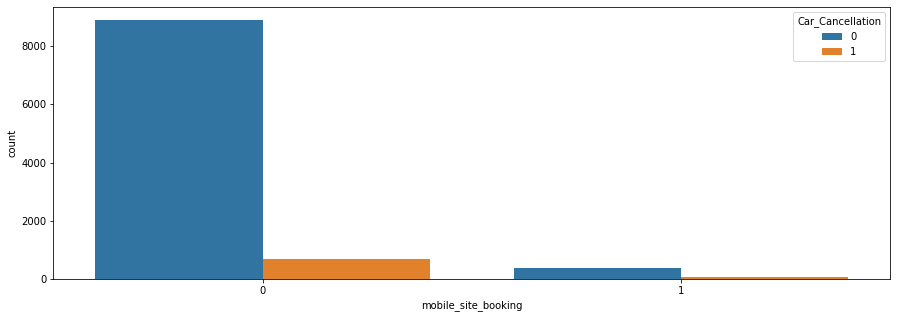

In [41]:
# Cateforical EDA
import seaborn as sns

cat_vars = ['user_id', 'vehicle_model_id', 'package_id', 'travel_type_id', 'online_booking', 'mobile_site_booking']
for col in cat_vars:
  plt.figure(figsize=(15,5))
  ax = sns.countplot(data = taxi_df, x = col, hue = 'Car_Cancellation')
  plt.show()

In [42]:
print('******************')
print('Car Cancellation Balance:')
print('******************')
print(taxi_df.Car_Cancellation.value_counts(dropna=False, normalize = True))
print('\n')
for col in cat_vars:
  print('******************')
  print('{} split:'.format(col))
  print('******************')
  p1 = taxi_df[(taxi_df.Car_Cancellation == 1)].groupby(col).size().reset_index(name='Car_Cancellation_Counts')
  p2 = taxi_df.groupby(col).size().reset_index(name='Total_Scheduled_Car_Counts')
  p1['Total_Scheduled_Car_Counts'] = p2['Total_Scheduled_Car_Counts']
  p1['Percent_Cancelled'] = p1['Car_Cancellation_Counts']/p2['Total_Scheduled_Car_Counts']
  p1['Percent_Cancelled_Total'] = (p1['Car_Cancellation_Counts']/p1['Car_Cancellation_Counts'].sum()) 
  p1['Percent_Scheduled_Total'] = (p2['Total_Scheduled_Car_Counts']/p2['Total_Scheduled_Car_Counts'].sum()) 
  p1['Cancelled_Index'] = (1.0*p1['Percent_Cancelled_Total']) / (1.0*p1['Percent_Scheduled_Total']) 
  print(p1.sort_values(by=['Cancelled_Index']))
  print('\n')

******************
Car Cancellation Balance:
******************
0    0.9257
1    0.0743
Name: Car_Cancellation, dtype: float64


******************
user_id split:
******************
     user_id  Car_Cancellation_Counts  Total_Scheduled_Car_Counts  \
0         16                        0                           1   
4530   37147                        0                           1   
4529   37146                        0                           1   
4528   37144                        0                           2   
4527   37140                        0                           1   
...      ...                      ...                         ...   
1543   24588                        1                           1   
5625   41759                        1                           1   
6571   46191                        1                           1   
2550   28735                        3                           3   
3108   31167                        3                      

Numeric EDA

In [50]:
taxi_df.columns

Index(['row#', 'user_id', 'vehicle_model_id', 'package_id', 'travel_type_id',
       'from_area_id', 'to_area_id', 'from_city_id', 'to_city_id', 'from_date',
       'to_date', 'online_booking', 'mobile_site_booking', 'booking_created',
       'from_lat', 'from_long', 'to_lat', 'to_long', 'Car_Cancellation',
       'dist(km)', 'from_date_year', 'from_date_month', 'from_date_day',
       'from_date_hour', 'from_date_minute', 'to_date_year', 'to_date_month',
       'to_date_day', 'to_date_hour', 'to_date_minute', 'booking_created_year',
       'booking_created_month', 'booking_created_day', 'booking_created_hour',
       'booking_created_minute', 'time_delta(secs)'],
      dtype='object')

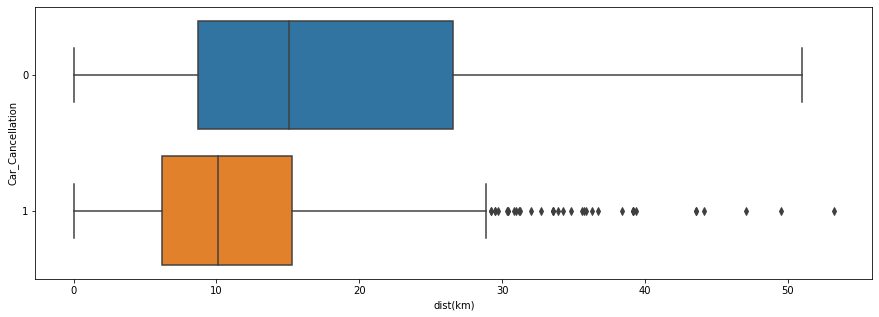

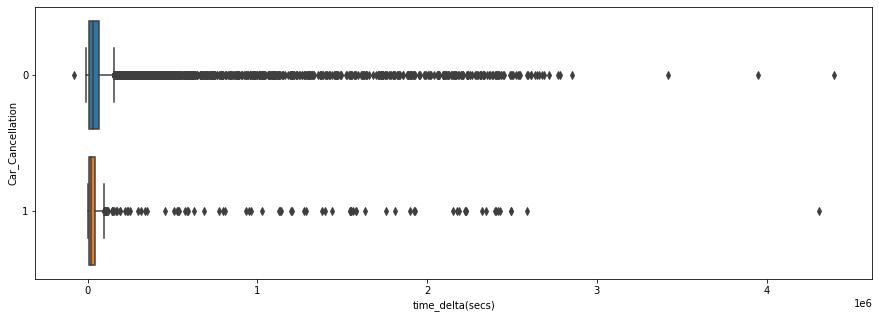

In [52]:
#Numeric EDA
num_vars = ['dist(km)', 'time_delta(secs)']

%matplotlib inline
temp_df = taxi_df
temp_df["Car_Cancellation"] = temp_df["Car_Cancellation"].astype("category")

for col in num_vars:
  plt.figure(figsize=(15,5))
  ax = sns.boxplot(data = temp_df, x = col, y = 'Car_Cancellation')
  plt.show()

Correlation Analysis

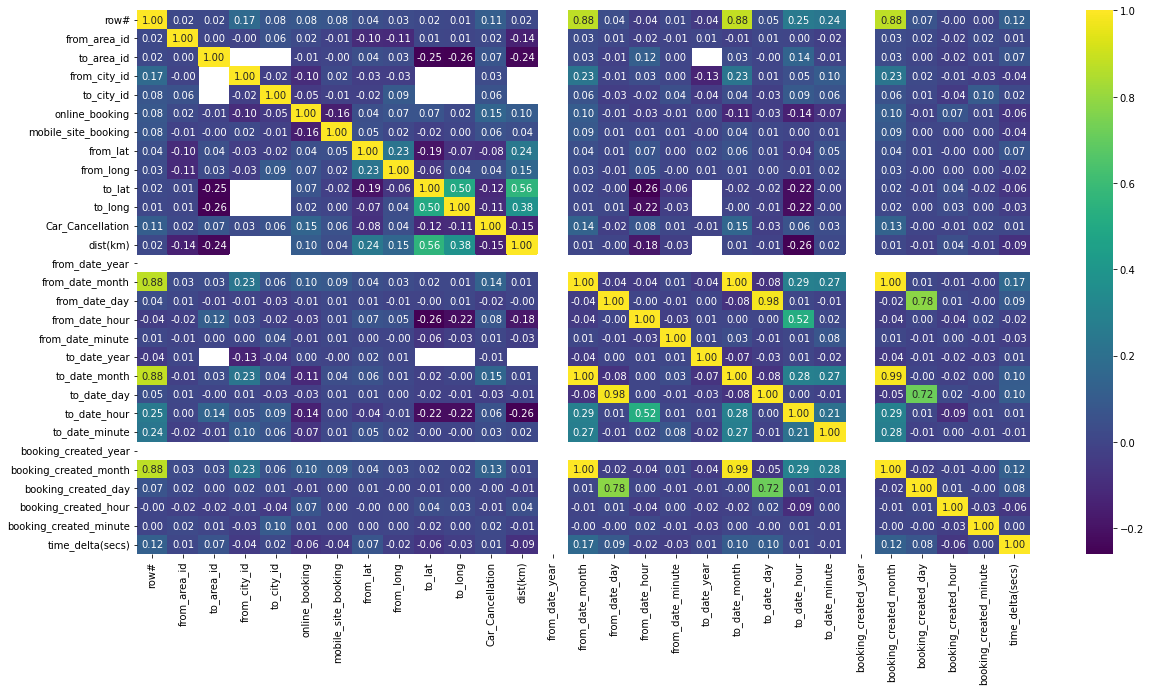

In [45]:
#correlation Analysis
plt.subplots(figsize=(20,10))
sns.heatmap(taxi_df.corr(), annot = True, fmt = ".2f", cmap = "viridis");

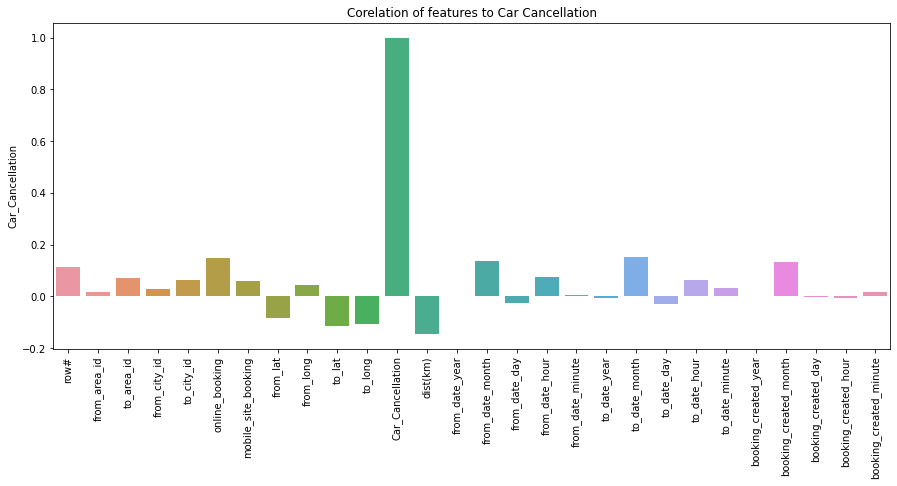

In [47]:
corr = taxi_df.corr().Car_Cancellation
plt.figure(figsize = (15,6))
sns.barplot(x = corr[:-1].index, y = corr[:-1])
plt.title("Corelation of features to Car Cancellation")
plt.xticks(rotation=90);

Split Data

In [38]:
# Assign Dependant and Independant Variables
X = taxi_df.drop(['row#', 'Car_Cancellation', 'from_date',	'to_date', 'booking_created'], axis=1)
y = taxi_df['Car_Cancellation']
# partition the data into training (60%) and validation (40%) sets. use random_state=1 for reproducibility of results
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

In [53]:
taxi_df.shape

(10000, 36)

In [56]:
# alternative way using scikit-learn
train, temp = train_test_split(taxi_df, train_size=0.4, random_state=1)
valid, test = train_test_split(temp, train_size=0.6, random_state=1)

print('Training   : ', train.shape)
print('Validation : ', valid.shape)
print('Test : ', test.shape)

Training   :  (4000, 36)
Validation :  (3600, 36)
Test :  (2400, 36)


In [76]:
# Predictor List
predictors = taxi_df.columns.values.tolist()
# Identify and remove Y from Predictors
outcome = 'Car_Cancellation'
predictors.remove(outcome)
# items to be removed from list.
omit = ['row#', 'Car_Cancellation', 'from_date',	'to_date', 'booking_created']

predictors = [i for i in predictors if i not in omit]

# show Predictor list
print(predictors)

['user_id', 'vehicle_model_id', 'package_id', 'travel_type_id', 'from_area_id', 'to_area_id', 'from_city_id', 'to_city_id', 'online_booking', 'mobile_site_booking', 'from_lat', 'from_long', 'to_lat', 'to_long', 'dist(km)', 'from_date_year', 'from_date_month', 'from_date_day', 'from_date_hour', 'from_date_minute', 'to_date_year', 'to_date_month', 'to_date_day', 'to_date_hour', 'to_date_minute', 'booking_created_year', 'booking_created_month', 'booking_created_day', 'booking_created_hour', 'booking_created_minute', 'time_delta(secs)']


In [78]:
from sklearn.linear_model import LogisticRegressionCV

train_X = train[predictors]
train_y = train[outcome]
valid_X = valid[predictors]
valid_y = valid[outcome]

# scale = MinMaxScaler()
# train_X = scale.fit_transform(train_X)
model = LogisticRegressionCV(penalty="l2", solver='lbfgs', cv=5, max_iter=500)
model.fit(train_X, train_y)

print('regularization', model.C_)
print('intercept ', model.intercept_[0])
df = pd.DataFrame({
    'coeff': model.coef_[0], 
    'abs_coeff': np.abs(model.coef_[0])
}, index=predictors)
print(df.sort_values(by=['abs_coeff'], ascending=False))

ValueError: ignored

Preform Exploratory Modeling

In [ ]:
# fit the tree
smallClassTree = DecisionTreeClassifier(max_depth=7, min_samples_split=50, min_impurity_decrease=0.01)
smallClassTree.fit(train_X, train_y)

plotDecisionTree(smallClassTree, feature_names=train_X.columns)

Pairplots

---
**Question 3.4 Answer:**<br>
ugh
---

---
## Question 4
Fit several predictive models of your choice. Do they provide information on how the predictor variables relate to cancellations? (15 Points)


Logistic Regression

In [ ]:
# Apply logistic regression, neural networks, decision tree, and random forest classifiers to predict rideshare cancelations.

# Model: Logistic Regress to identify important variables.

from dmba.metric import AIC_score
from dmba import classificationSummary, gainsChart, liftChart

train_X = trainNorm.drop(['Purchase', 'Spending','sequence_number'], axis=1)
train_y = trainNorm['Purchase']
valid_X = validNorm.drop(['Purchase', 'Spending','sequence_number'], axis=1)
valid_y = validNorm['Purchase']

logit_rlr = LogisticRegressionCV(penalty="l2", solver='liblinear')
logit_rlr.fit(train_X, train_y)

print('regularization', logit_rlr.C_, '\n')
print('intercept ', logit_rlr.intercept_[0], '\n')

display(pd.DataFrame({'coeff': logit_rlr.coef_[0]}, index=train_X.columns).transpose())

print('\nAIC', AIC_score(valid_y, logit_rlr.predict(valid_X), df=len(train_X.columns) + 1), '\n')

# confusion matrix
classificationSummary(valid_y, logit_rlr.predict(valid_X))


logit_reg_pred = logit_full.predict_proba(valid_X)
full_result = pd.DataFrame({'actual': valid_y, 
                            'p(0)': [p[0] for p in logit_reg_pred],
                            'p(1)': [p[1] for p in logit_reg_pred],
                            'predicted': logit_full.predict(valid_X)})
full_result = full_result.sort_values(by=['p(1)'], ascending=False)

Nueral Networks

Decision Tree

In [ ]:
# user grid search to find optimized tree
param_grid = {
    'max_depth': [1, 2, 3, 4, 5, 10, 15, 20, 25], 
    'min_impurity_decrease': [0, 0.00001, 0.0001, 0.001, 0.005, 0.01], 
    'min_samples_split': [5, 10, 20, 30, 40, 50], 
}
gridSearch = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('Initial parameters: ', gridSearch.best_params_)

In [ ]:
# use first grid search to find more optimal hyperparamters.
param_grid = {
    'max_depth': [5, 6, 7, 8, 9, 10], 
    'min_impurity_decrease': [0, 0.000001, 0.000002, 0.000003, 0.000005, 0.000006, 0.000007, 0.000008], 
    'min_samples_split': [6,7,8,9,10,11,12,13,14,15,16,18,20], 
}
gridSearch = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('Improved parameters: ', gridSearch.best_params_)

regTree = gridSearch.best_estimator_

print('\nTraining Results:')
pred_y = regTree.predict(train_X)
regressionSummary(train_y, pred_y)

print('\nValidation Results:')
pred_y = regTree.predict(valid_X)
regressionSummary(valid_y, pred_y)

Random Forest


---
**Question 4 Answer:**<br>
ugh
---

---
## Question 5
Report the predictive performance of your model in terms of error rates (the confusion matrix). How well does the model perform? Can the model be used in practice? (10 Points)

In [ ]:


# confusion matrix
classificationSummary(full_result.actual, full_result.predicted, class_names=classes)

---
**Question 5 Answer:**<br>
ugh
---

---
## Question 6
Examine the predictive performance of your model in terms of ranking (lift). How well does the model perform? Can the model be used in practice? (10 Points)


In [ ]:
Score_Analysis_pred_rev = Score_Analysis_pred_rev.sort_values(by=['expected spending'], ascending=False)
# Gains and Lift Chart
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
gainsChart(Score_Analysis_pred_rev.Spending, ax=axes[0])
liftChart(Score_Analysis_pred_rev.Spending, title=False, ax=axes[1])
axes[0].set_title('Cumulative Gains Chart - Test Data Results')
axes[1].set_title('Cumulative Lift Chart - Test Data Results')

plt.show()

In [ ]:
logit_reg_proba = logit_red.predict_proba(valid_X)
red_result = pd.DataFrame({'actual': valid_y, 
                            'p(0)': [p[0] for p in logit_reg_proba],
                            'p(1)': [p[1] for p in logit_reg_proba],
                            'predicted': logit_red.predict(valid_X),
                          })
red_result = red_result.sort_values(by=['p(1)'], ascending=False)

ax = gainsChart(full_result.actual, label='Full model', color='C1', figsize=[5, 5])
ax = gainsChart(red_result.actual, label='Reduced model', color='C0', ax=ax)
ax.legend()
ax.set_title('Logistic Regression Using Fewer Predictors vs. Full Model')

plt.show()

---
**Question 6 Answer:**<br>
ugh
---

---
## Question 7
Briefly explain, in two to three paragraphs, the business objective, the data mining models used, why they were used, the model results, and your recommendations to your non-technical stakeholder team. (10 Points)


---
**Question 7 Answer:**<br>
ugh
---